In [1]:
# link the paths
import os, sys
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random
from matplotlib.colors import ListedColormap

from src.dataset import load_partition, SICAPv2Dataset
from src.attention_unet import AttentionUNet
from src.transforms import get_val_transform
from src.train import get_device

In [3]:
# link datasets

DATA_ROOT = os.path.join(project_root, "data", "SICAPv2")
IMAGES = os.path.join(DATA_ROOT, "images")
MASKS = os.path.join(DATA_ROOT, "masks")
TEST_XLSX = os.path.join(DATA_ROOT, "partition", "Test", "Test.xlsx")

CHECKPOINT = os.path.join(project_root, "experiments", "final", "best_model.pth")

# Set this according to model used in training
NUM_CLASSES=2

In [4]:
img_paths, mask_paths, labels = load_partition(TEST_XLSX, IMAGES, MASKS)
test_ds = SICAPv2Dataset(img_paths, mask_paths, labels, transform=get_val_transform())
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Test samples:", len(test_ds))

Test samples: 2122


Sample image indexes to view

1380, 948, 522, 741, 1377,1011, 1517, 708, 1435

In [40]:
idx = 1380
# idx = random.randint(0, len(test_ds)-1)  

image_tensor, gt_mask = test_ds[idx]

img_path = test_ds.image_paths[idx]
mask_path = test_ds.mask_paths[idx]

print("Image path:", img_path)
print("Mask path :", mask_path)

device = get_device()

model = AttentionUNet(in_channels=3, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(CHECKPOINT, map_location=device))
model.to(device)
model.eval()

print(idx)

Image path: /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/data/SICAPv2/images/18B0006169B_Block_Region_6_5_6_xini_32934_yini_92413.jpg
Mask path : /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/data/SICAPv2/masks/18B0006169B_Block_Region_6_5_6_xini_32934_yini_92413.jpg
Using Apple Metal (MPS) GPU
1380


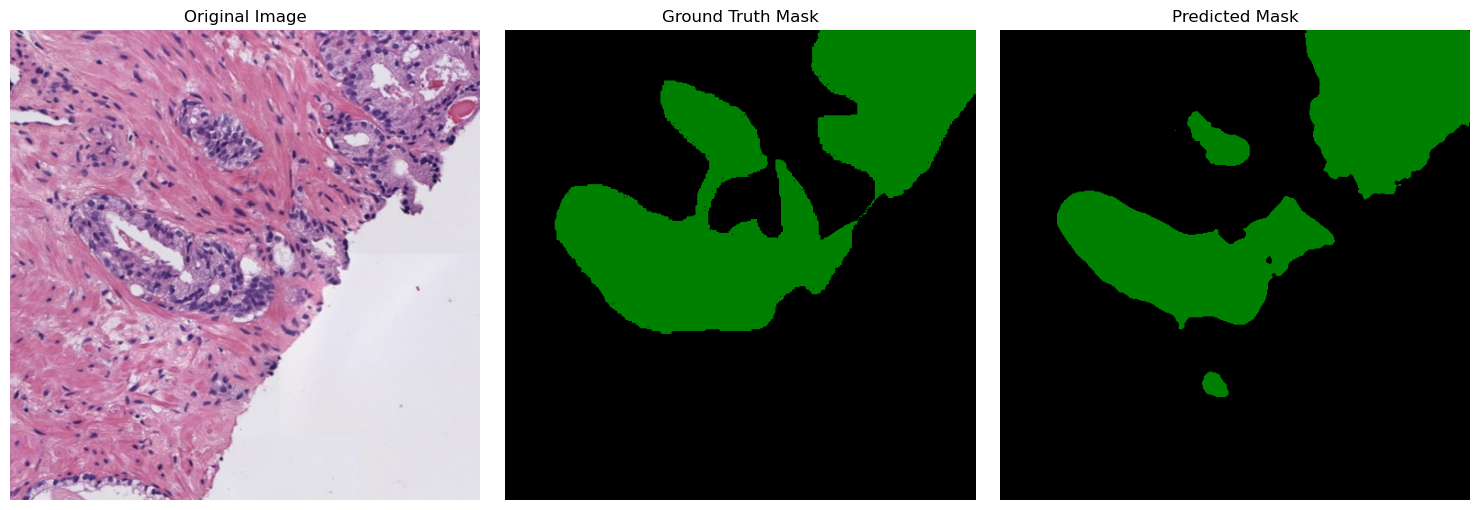

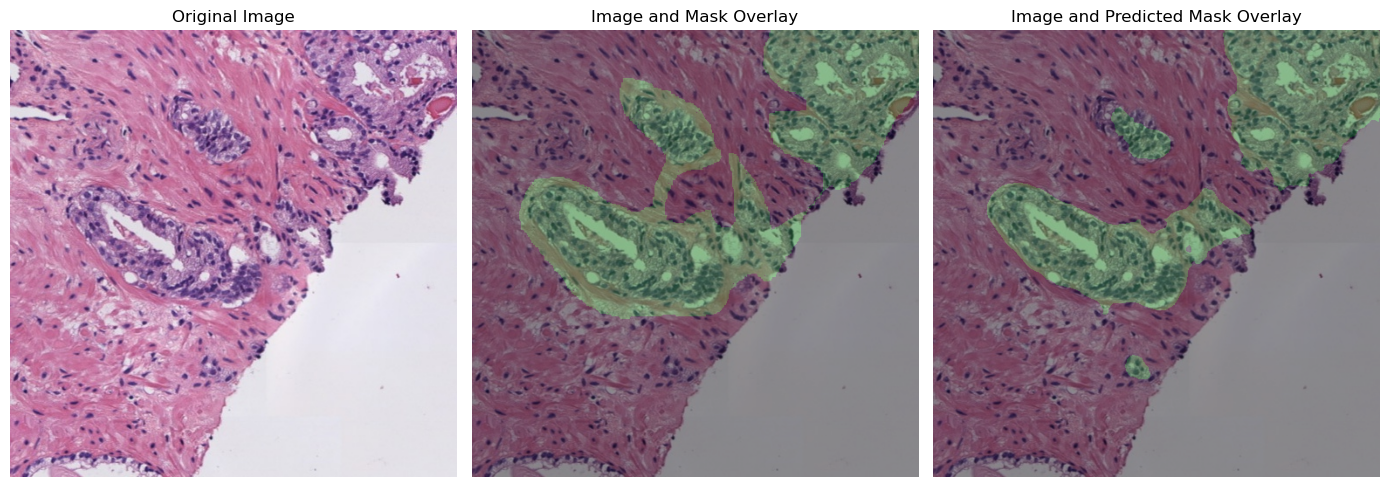

In [41]:
with torch.no_grad():
    input_tensor = image_tensor.unsqueeze(0).to(device)  
    logits = model(input_tensor)
    pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu()
    
image_np = image_tensor.permute(1, 2, 0).numpy()

gt_mask_np = gt_mask.numpy()
pred_mask_np = pred_mask.numpy()

# 0: background, 1: GG3, 2: GG4, 3: GG5
cmap = ListedColormap(["black", "green", "yellow", "red"])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask_np, cmap=cmap, vmin=0, vmax=3)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_np, cmap=cmap, vmin=0, vmax=3)
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

cmap = ListedColormap([
    "black",  # background
    "green"     # tissue
])

plt.figure(figsize=(14, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

# GT overlay
plt.subplot(1, 3, 2)
plt.imshow(image_np)
plt.imshow(gt_mask_np, cmap=cmap, alpha=0.4, vmin=0, vmax=1)
plt.title("Image and Mask Overlay")
plt.axis("off")

# Prediction overlay
plt.subplot(1, 3, 3)
plt.imshow(image_np)
plt.imshow(pred_mask_np, cmap=cmap, alpha=0.4, vmin=0, vmax=1)
plt.title("Image and Predicted Mask Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

In [42]:
print("GT mask class distribution:", np.unique(gt_mask_np, return_counts=True))
print("Pred mask class distribution:", np.unique(pred_mask_np, return_counts=True))

GT mask class distribution: (array([0, 1]), array([196815,  65329]))
Pred mask class distribution: (array([0, 1]), array([209656,  52488]))
